In [28]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 350)
#!pip install pyspellchecker
from spellchecker import SpellChecker
import spacy
import scipy
import string, re, nltk
from string import punctuation
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
#nltk.download('averaged_perceptron_tagger')

In [29]:
cols_to_read = ['Summary', 'Issue key', 'Issue id', 'Issue Type', 'Status', 'Priority', 'Resolution', 'Assignee', 'Reporter', 
            'Creator', 'Created', 'Resolved', 'Description', 'Environment','Custom field (Requested From:)','Custom field ([CHART] Date of First Response)',
            'Parent', 'Status Category', 'Status Category Changed']

In [30]:
df1 = pd.read_csv("./data/jira2/JIRA_product_bug_done_parent.csv", usecols=cols_to_read)
df1.shape

(716, 19)

In [31]:
cols_to_read.remove('Parent')
df2 = pd.read_csv("./data/jira2/JIRA_product_bug_done_noparent.csv", usecols=cols_to_read)
df2.shape

(682, 18)

In [32]:
df = pd.concat([df1, df2], ignore_index=True)
df.head()

,Summary,Issue key,Issue id,Issue Type,Status,Priority,Resolution,Assignee,Reporter,Creator,Created,Resolved,Description,Environment,Custom field (Requested From:),Custom field ([CHART] Date of First Response),Parent,Status Category,Status Category Changed
0,Remove URL length limit for Work Instructions...,PAR-8868,70267,Bug,Done,Medium,NaN,Hugo Li [42-Q],Fannie Yi [42-Q],Fannie Yi [42-Q],02/Jul/24 11:11 PM,NaN,*Steps to reproduce:*\n\n# Go to the site: [ht...,NaN,Engineering (Dev),2024-07-04 03:45:41.885,67983.0,Done,05/Jul/24 3:20 AM
1,SR 5715427 - E30 PIDs MSD null value in Fuji d...,PAR-8869,70152,Bug,Done,Highest,NaN,Farton Fang [42-Q],MES Support Freshdesk acct,MES Support Freshdesk acct,01/Jul/24 6:25 PM,NaN,This Jira aims to change the data update logic...,NaN,Engineering (Dev),2024-07-04 03:05:51.229,68634.0,Done,10/Jul/24 5:05 AM
2,Media API change to get the jwks.json file fro...,PAR-8339,69343,Bug,Done,Medium,NaN,levi.xiong,Sunny Xiong [42-Q],Sunny Xiong [42-Q],16/Jun/24 10:46 PM,NaN,The team found the current MES16 media APi go...,NaN,Engineering (Dev),NaN,69246.0,Done,02/Jul/24 9:13 PM
3,[MES16] Work Instructions failed to retrieve t...,PAR-8275,69063,Bug,Done,Medium,NaN,Hugo Li [42-Q],Fannie Yi [42-Q],Fannie Yi [42-Q],03/Jun/24 4:00 AM,NaN,"Generally, Work Instructions Service gets the ...",NaN,Engineering (Dev),2024-06-06 05:59:02.594,67983.0,Done,06/Jun/24 3:57 AM
4,[Work Instructions][Device Maintenance] - Fix ...,PAR-8239,68990,Bug,Done,Medium,NaN,Hugo Li [42-Q],Fannie Yi [42-Q],Fannie Yi [42-Q],30/May/24 3:57 AM,NaN,Problem Statement:\n\nAn issue was found in th...,NaN,Engineering (Dev),2024-05-31 07:28:07.995,67983.0,Done,03/Jun/24 10:36 PM


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1398 entries, 0 to 1397
Data columns (total 19 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Summary                                        1398 non-null   object 
 1   Issue key                                      1398 non-null   object 
 2   Issue id                                       1398 non-null   int64  
 3   Issue Type                                     1398 non-null   object 
 4   Status                                         1398 non-null   object 
 5   Priority                                       1398 non-null   object 
 6   Resolution                                     217 non-null    object 
 7   Assignee                                       1362 non-null   object 
 8   Reporter                                       1398 non-null   object 
 9   Creator                                        1398 

In [34]:
df =df.rename(columns={
    'Custom field (Requested From:)': 'Request From',
    'Custom field ([CHART] Date of First Response)': 'First Response'
})
df['Created'] = pd.to_datetime(df['Created'])
df['Resolved'] = pd.to_datetime(df['Resolved'])
df['First Response'] = pd.to_datetime(df['First Response'])
df['Parent'] = df['Parent'].fillna(0)
df['Parent'] = df['Parent'].astype(int)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1398 entries, 0 to 1397
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Summary                  1398 non-null   object        
 1   Issue key                1398 non-null   object        
 2   Issue id                 1398 non-null   int64         
 3   Issue Type               1398 non-null   object        
 4   Status                   1398 non-null   object        
 5   Priority                 1398 non-null   object        
 6   Resolution               217 non-null    object        
 7   Assignee                 1362 non-null   object        
 8   Reporter                 1398 non-null   object        
 9   Creator                  1398 non-null   object        
 10  Created                  1398 non-null   datetime64[ns]
 11  Resolved                 217 non-null    datetime64[ns]
 12  Description              1381 non-

In [36]:
df['Status'].value_counts()

Status
Done    1398
Name: count, dtype: int64

In [37]:
# 计算时间间隔，并转换为小时
df['Response Time'] = (df['First Response'] - df['Created']).dt.total_seconds() / 60 / 60
df['Resolved Time'] = (df['Resolved'] - df['Created']).dt.total_seconds() / 60 / 60
df.head()

,Summary,Issue key,Issue id,Issue Type,Status,Priority,Resolution,Assignee,Reporter,Creator,Created,Resolved,Description,Environment,Request From,First Response,Parent,Status Category,Status Category Changed,Response Time,Resolved Time
0,Remove URL length limit for Work Instructions...,PAR-8868,70267,Bug,Done,Medium,NaN,Hugo Li [42-Q],Fannie Yi [42-Q],Fannie Yi [42-Q],2024-07-02 23:11:00,NaT,*Steps to reproduce:*\n\n# Go to the site: [ht...,NaN,Engineering (Dev),2024-07-04 03:45:41.885,67983,Done,05/Jul/24 3:20 AM,28.578301,NaN
1,SR 5715427 - E30 PIDs MSD null value in Fuji d...,PAR-8869,70152,Bug,Done,Highest,NaN,Farton Fang [42-Q],MES Support Freshdesk acct,MES Support Freshdesk acct,2024-07-01 18:25:00,NaT,This Jira aims to change the data update logic...,NaN,Engineering (Dev),2024-07-04 03:05:51.229,68634,Done,10/Jul/24 5:05 AM,56.680897,NaN
2,Media API change to get the jwks.json file fro...,PAR-8339,69343,Bug,Done,Medium,NaN,levi.xiong,Sunny Xiong [42-Q],Sunny Xiong [42-Q],2024-06-16 22:46:00,NaT,The team found the current MES16 media APi go...,NaN,Engineering (Dev),NaT,69246,Done,02/Jul/24 9:13 PM,NaN,NaN
3,[MES16] Work Instructions failed to retrieve t...,PAR-8275,69063,Bug,Done,Medium,NaN,Hugo Li [42-Q],Fannie Yi [42-Q],Fannie Yi [42-Q],2024-06-03 04:00:00,NaT,"Generally, Work Instructions Service gets the ...",NaN,Engineering (Dev),2024-06-06 05:59:02.594,67983,Done,06/Jun/24 3:57 AM,73.984054,NaN
4,[Work Instructions][Device Maintenance] - Fix ...,PAR-8239,68990,Bug,Done,Medium,NaN,Hugo Li [42-Q],Fannie Yi [42-Q],Fannie Yi [42-Q],2024-05-30 03:57:00,NaT,Problem Statement:\n\nAn issue was found in th...,NaN,Engineering (Dev),2024-05-31 07:28:07.995,67983,Done,03/Jun/24 10:36 PM,27.518887,NaN


In [38]:
df.drop_duplicates(inplace = True)
df.reset_index(drop = True, inplace = True)

<h2>Summary Text Clustering</h2>
<h3>Text processing</h3>
<ol>
    <li>Convert Text to lowercasae</li>
    <li>Remove white space</li>
    <li>Remove punctuations</li>
    <li>Remove html tag</li>
    <li>Remove emojis</li>
    <li>Remove http url</li>
    <li>Convert acronyms</li>
    <li>Convert contraction</li>
    <li>Remove stopwords</li>
    <li>Correct spell</li>
    <li>Stemming and Lemmatization</li>
    <li>Discart on-alphabetic words</li>
    <li>Retainment of Relevant Parts of Speech</li>
    <li>Remove additional stopwords</li>
</ol>

In [39]:
# RegexpTokenizer
regexp = RegexpTokenizer("[\w']+")

# convert to lowercase
def convert_to_lowercase(text):
    return text.lower()

# remove whitespaces
def remove_whitespace(text):
    return text.strip()

# remove punctuations
def remove_punctuation(text):
    punct_str = string.punctuation
    punct_str = punct_str.replace("'", "")
    return text.translate(str.maketrans("", "", punct_str))

# remove html tags
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

# remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags = re.UNICODE)
    return emoji_pattern.sub(r'', text)

# remove http url in text
def remove_http(text):
    http = "https?://\S+|www\.\S+" # matching strings beginning with http (but not just "http")
    pattern = r"({})".format(http) # creating pattern
    return re.sub(pattern, "", text)

# Dictionary of acronyms
acronyms_url = './data/english_acronyms.json'
acronyms_dict = pd.read_json(acronyms_url, typ = 'series')
acronyms_list = list(acronyms_dict.keys())

# convert contractions in a text
def convert_acronyms(text):
    words = []
    for word in regexp.tokenize(text):
        if word in acronyms_list:
            words = words + acronyms_dict[word].split()
        else:
            words = words + word.split()
    
    text_converted = " ".join(words)
    return text_converted

# Dictionary of contractions
contractions_url = './data/english_contractions.json'
contractions_dict = pd.read_json(contractions_url, typ = 'series')
# List of contractions
contractions_list = list(contractions_dict.keys())

# convert contractions in a text
def convert_contractions(text):
    words = []
    for word in regexp.tokenize(text):
        if word in contractions_list:
            words = words + contractions_dict[word].split()
        else:
            words = words + word.split()
    
    text_converted = " ".join(words)
    return text_converted

# Stopwords
stops = stopwords.words("english")
addstops = ["among", "onto", "shall", "thrice", "thus", "twice", "unto", "us", "would", "issue"] # additional stopwords
allstops = stops + addstops

# remove stopwords
def remove_stopwords(text):
    return " ".join([word for word in regexp.tokenize(text) if word not in allstops])

spell = SpellChecker()
# spell correction
def pyspellchecker(text):
    word_list = regexp.tokenize(text)
    word_list_corrected = []
    for word in word_list:
        if word in spell.unknown(word_list):
            word_corrected = spell.correction(word)
            if word_corrected == None:
                word_list_corrected.append(word)
            else:
                word_list_corrected.append(word_corrected)
        else:
            word_list_corrected.append(word)
    text_corrected = " ".join(word_list_corrected)
    return text_corrected

# Stemming
stemmer = PorterStemmer()
def text_stemmer(text):
    text_stem = " ".join([stemmer.stem(word) for word in regexp.tokenize(text)])
    return text_stem

# Lemmatization
spacy_lemmatizer = spacy.load("en_core_web_sm", disable = ['parser', 'ner'])
#lemmatizer = WordNetLemmatizer()

def text_lemmatizer(text):
    text_spacy = " ".join([token.lemma_ for token in spacy_lemmatizer(text)])
    #text_wordnet = " ".join([lemmatizer.lemmatize(word) for word in word_tokenize(text)]) # regexp.tokenize(text)
    return text_spacy
    #return text_wordnet

# Discardment of non-alphabetic words
def discard_non_alpha(text):
    word_list_non_alpha = [word for word in regexp.tokenize(text) if word.isalpha()]
    text_non_alpha = " ".join(word_list_non_alpha)
    return text_non_alpha

# Retainment of Relevant Parts of Speech
def keep_pos(text):
    tokens = regexp.tokenize(text)
    tokens_tagged = nltk.pos_tag(tokens)
    #keep_tags = ['NN', 'NNS', 'NNP', 'NNPS', 'FW']
    keep_tags = ['NN', 'NNS', 'NNP', 'NNPS', 'FW', 'PRP', 'PRPS', 'RB', 'RBR', 'RBS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WPS', 'WRB']
    keep_words = [x[0] for x in tokens_tagged if x[1] in keep_tags]
    return " ".join(keep_words)

# Additional stopwords
alphabets = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]
prepositions = ["about", "above", "across", "after", "against", "among", "around", "at", "before", "behind", "below", "beside", "between", "by", "down", "during", "for", "from", "in", "inside", "into", "near", "of", "off", "on", "out", "over", "through", "to", "toward", "under", "up", "with"]
prepositions_less_common = ["aboard", "along", "amid", "as", "beneath", "beyond", "but", "concerning", "considering", "despite", "except", "following", "like", "minus", "onto", "outside", "per", "plus", "regarding", "round", "since", "than", "till", "underneath", "unlike", "until", "upon", "versus", "via", "within", "without"]
coordinating_conjunctions = ["and", "but", "for", "nor", "or", "so", "and", "yet"]
correlative_conjunctions = ["both", "and", "either", "or", "neither", "nor", "not", "only", "but", "whether", "or"]
subordinating_conjunctions = ["after", "although", "as", "as if", "as long as", "as much as", "as soon as", "as though", "because", "before", "by the time", "even if", "even though", "if", "in order that", "in case", "in the event that", "lest", "now that", "once", "only", "only if", "provided that", "since", "so", "supposing", "that", "than", "though", "till", "unless", "until", "when", "whenever", "where", "whereas", "wherever", "whether or not", "while"]
others = ["ã", "å", "ì", "û", "ûªm", "ûó", "ûò", "ìñ", "ûªre", "ûªve", "ûª", "ûªs", "ûówe"]
additional_stops = alphabets + prepositions + prepositions_less_common + coordinating_conjunctions + correlative_conjunctions + subordinating_conjunctions + others

def remove_additional_stopwords(text):
    return " ".join([word for word in regexp.tokenize(text) if word not in additional_stops])

In [40]:
def text_normalizer(text):
    text = convert_to_lowercase(text)
    text = remove_whitespace(text)
    text = re.sub('\n' , '', text) # converting text to one line
    text = re.sub('\[.*?\]', '', text) # removing square brackets
    text = remove_http(text)
    text = remove_punctuation(text)
    text = remove_html(text)
    text = remove_emoji(text)
    text = convert_acronyms(text)
    text = convert_contractions(text)
    text = remove_stopwords(text)
    text = pyspellchecker(text)
    text = text_lemmatizer(text)
    text = discard_non_alpha(text)
    text = keep_pos(text)
    text = remove_additional_stopwords(text)
    return text

In [41]:
df['normalized_summary'] = df['Summary'].apply(text_normalizer)

In [42]:
df['normalized_summary']

0       remove curl length limit work instruction mapp...
1                                 kid value fiji database
2           medium ape change get jwksjson file path path
3       work instruction fail retrieve parameter value...
4                                         time issue mess
                              ...                        
1393                                                  bug
1394                       button doc mapping part family
1395                     end host interface work loadcomp
1396                shop order browser export column name
1397                profile name create boy export option
Name: normalized_summary, Length: 1398, dtype: object

In [43]:
vector = CountVectorizer(ngram_range=(1, 3))
X = vector.fit(df['normalized_summary'])
X_transform = X.transform(df['normalized_summary'])

In [44]:
print(X_transform.shape)
pd.DataFrame(X_transform.toarray(), columns=vector.get_feature_names_out()).head(5)

(1398, 9830)


,abandon,abandon pool,ability,ability edit,ability edit shift,abnormal,accept,accept datum,accept datum zero,access,access cam,access cam mess,access chart,access chart email,access control,access control issue,access download,access download login,access issue,access issue maintenance,access landing,access landing page,access provide,access provide sense,access spy,access spy configuration,access unit,access unit production,access user,access user disable,accord,accord work,accord work order,account,account access,account access issue,account ape,account ape gateway,account login,account login mess,accurate,accurately,accuser,actinia,actinia backup,action,action code,action code description,action contain,action contain finisher,action crew,action history,action pause,action pause resume,action reflect,action reflect page,action take,action take part,action work,action work multiscan,activate,activate edit,activate edit description,activate me,activation,activation publication,activation publication parent,activity,activity already,activity already step,activity load,activity load draft,activity monitor,activity monitor date,activity monitor fix,activity monitor review,activity monitorinspection,activity monitorinspection review,activity properly,activity properly let,activity station,activity station set,activity summary,activity time,activity time recording,activitymeaskey,ad,ad function,ad function call,add,add attachment,add attribute,add batch,add batch assembly,add button,add cad,add cad file,add case,add case hold,add chapter,add chapter bug,add checkbook,add checkbook work,add client,add client device,add command,add command station,add comment,add comment use,add component,add container,add container default,add container even,add creation,add creation custom,add crew,add deviation,add deviation mapping,add display,add display page,add downtime,add downtime record,add duplicate,add duplicate part,add edit,add error,add event,add event endpoint,add index,add index machineevent,add line,add line cpkppk,add line get,add material,add material queue,add measurementsattributes,add measurementsattributes unit,add mesa,add mesa take,add modify,add modify exception,add monitor,add problem,add problem category,add reach,add reach location,add reference,add reference designator,add scroll,add scroll document,add set,add standard,add standard hold,add track,add track component,add unit,add unit status,add user,add verification,add verification modify,addattribute,addattribute method,addattribute method support,addelement,addelement closecontainer,addelement closecontainer cleveloperation,adjust,adjust labor,adjust labor time,administration,administration crew,administration crew maintenance,administrator,administrator access,admit,...,work instruction fail,work instruction image,work instruction issue,work instruction mapping,work instruction module,work instruction palm,work instruction search,work instruction take,work lay,work lay command,work loadcomp,work lot,work lot end,work lowercase,work lowercase shop,work mess,work multiscan,work order,work order asset,work order assign,work order check,work order conduction,work order create,work order dashboard,work order delete,work order detail,work order display,work order error,work order field,work order flow,work order module,work order notification,work order problem,work order status,work page,work properly,work properly adopt,work properly duplicate,work property,work pub,work pub containerization,work quote,work quote string,work request,work request email,work scanning,work screen,work shop,work shop order,work site,work site use,work target,work target name,work target problem,work tomcat,work vulgarian,work work,work work date,work work instruction,workbench,workbench asset,workbench asset button,workbench call,workbench call conduit,workbench change,workbench change serial,workbench check,workbench check status,workbench container,workbench container print,workbench co

In [45]:
Tfidf = TfidfTransformer()
tfidf_transformer = Tfidf.fit(X_transform)
X = tfidf_transformer.transform(X_transform)

In [46]:
print(X.shape)
df_tfidf = pd.DataFrame(X.toarray(), columns=vector.get_feature_names_out())
df_tfidf.head(5)

(1398, 9830)


,abandon,abandon pool,ability,ability edit,ability edit shift,abnormal,accept,accept datum,accept datum zero,access,access cam,access cam mess,access chart,access chart email,access control,access control issue,access download,access download login,access issue,access issue maintenance,access landing,access landing page,access provide,access provide sense,access spy,access spy configuration,access unit,access unit production,access user,access user disable,accord,accord work,accord work order,account,account access,account access issue,account ape,account ape gateway,account login,account login mess,accurate,accurately,accuser,actinia,actinia backup,action,action code,action code description,action contain,action contain finisher,action crew,action history,action pause,action pause resume,action reflect,action reflect page,action take,action take part,action work,action work multiscan,activate,activate edit,activate edit description,activate me,activation,activation publication,activation publication parent,activity,activity already,activity already step,activity load,activity load draft,activity monitor,activity monitor date,activity monitor fix,activity monitor review,activity monitorinspection,activity monitorinspection review,activity properly,activity properly let,activity station,activity station set,activity summary,activity time,activity time recording,activitymeaskey,ad,ad function,ad function call,add,add attachment,add attribute,add batch,add batch assembly,add button,add cad,add cad file,add case,add case hold,add chapter,add chapter bug,add checkbook,add checkbook work,add client,add client device,add command,add command station,add comment,add comment use,add component,add container,add container default,add container even,add creation,add creation custom,add crew,add deviation,add deviation mapping,add display,add display page,add downtime,add downtime record,add duplicate,add duplicate part,add edit,add error,add event,add event endpoint,add index,add index machineevent,add line,add line cpkppk,add line get,add material,add material queue,add measurementsattributes,add measurementsattributes unit,add mesa,add mesa take,add modify,add modify exception,add monitor,add problem,add problem category,add reach,add reach location,add reference,add reference designator,add scroll,add scroll document,add set,add standard,add standard hold,add track,add track component,add unit,add unit status,add user,add verification,add verification modify,addattribute,addattribute method,addattribute method support,addelement,addelement closecontainer,addelement closecontainer cleveloperation,adjust,adjust labor,adjust labor time,administration,administration crew,administration crew maintenance,administrator,administrator access,admit,...,work instruction fail,work instruction image,work instruction issue,work instruction mapping,work instruction module,work instruction palm,work instruction search,work instruction take,work lay,work lay command,work loadcomp,work lot,work lot end,work lowercase,work lowercase shop,work mess,work multiscan,work order,work order asset,work order assign,work order check,work order conduction,work order create,work order dashboard,work order delete,work order detail,work order display,work order error,work order field,work order flow,work order module,work order notification,work order problem,work order status,work page,work properly,work properly adopt,work properly duplicate,work property,work pub,work pub containerization,work quote,work quote string,work request,work request email,work scanning,work screen,work shop,work shop order,work site,work site use,work target,work target name,work target problem,work tomcat,work vulgarian,work work,work work date,work work instruction,workbench,workbench asset,workbench asset button,workbench call,workbench call conduit,workbench change,workbench change serial,workbench check,workbench check status,workbench container,workbench container print,workbench co

<h2>Text Clustering</h2>

In [97]:
# For Clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
# For Styling
plt.style.use('default')

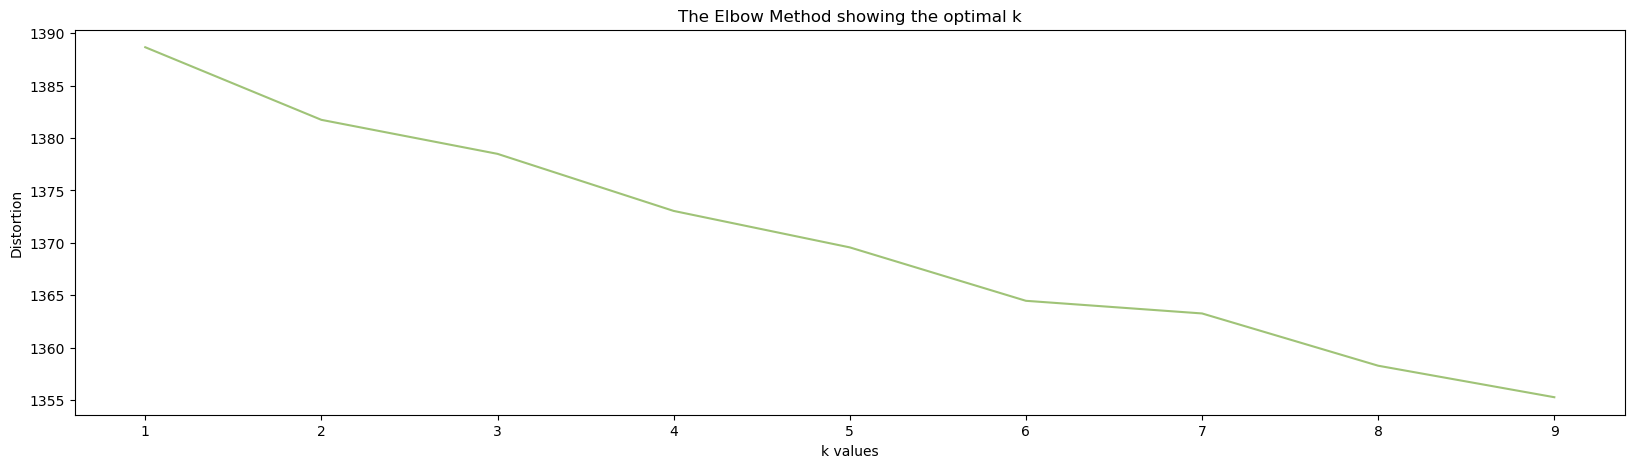

In [98]:
distortions = []
K = range(1,10)
for k in K:
    kmean = KMeans(n_clusters=k,random_state=7)
    kmean.fit(X)
    distortions.append(kmean.inertia_)
    
plt.figure(figsize=(20,5))
plt.plot(K, distortions, '-',color='g')
plt.xlabel('k values')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

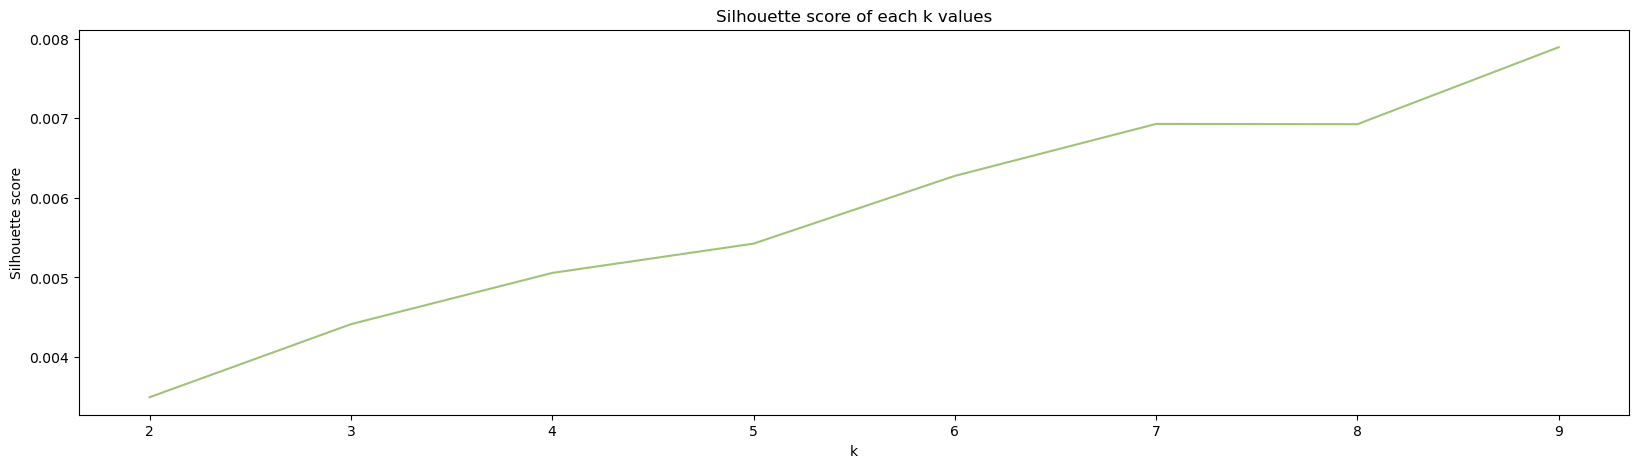

In [99]:
K = range(2,10)
silhouette = []
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    preds = kmeanModel.predict(X)
    silhouette.append(silhouette_score(X, preds))
    
plt.figure(figsize=(20,5))
plt.plot(K, silhouette, '-',color='g')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette score of each k values')
plt.show()

In [100]:
pca = PCA(n_components=2)
PCA = pca.fit(X.toarray())
X_pca = pca.transform(X.toarray())
pca.explained_variance_

array([0.00731533, 0.00484823])

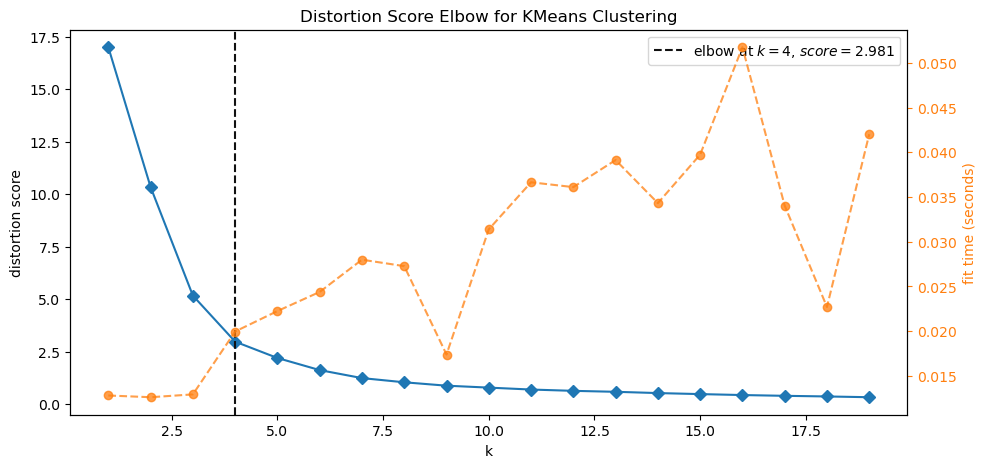

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [102]:
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(1,20),size=(1080, 500))

visualizer.fit(X_pca)        
visualizer.show() 

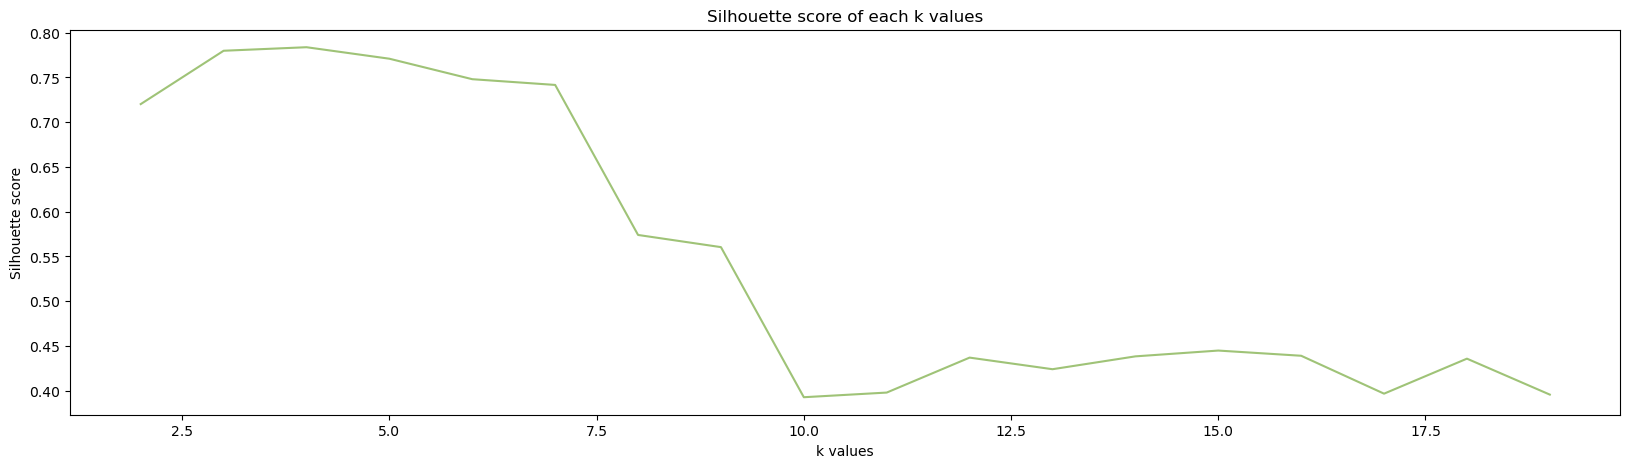

In [103]:
silhouette = []
K = range(2,20)

for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_pca)
    preds = kmeanModel.predict(X_pca)
    silhouette.append(silhouette_score(X_pca, preds))
    
plt.figure(figsize=(20,5))
plt.plot(K, silhouette, '-',color='g')
plt.xlabel('k values')
plt.ylabel('Silhouette score')
plt.title('Silhouette score of each k values')
plt.show()

In [107]:
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_pca)
labels = kmeans.labels_

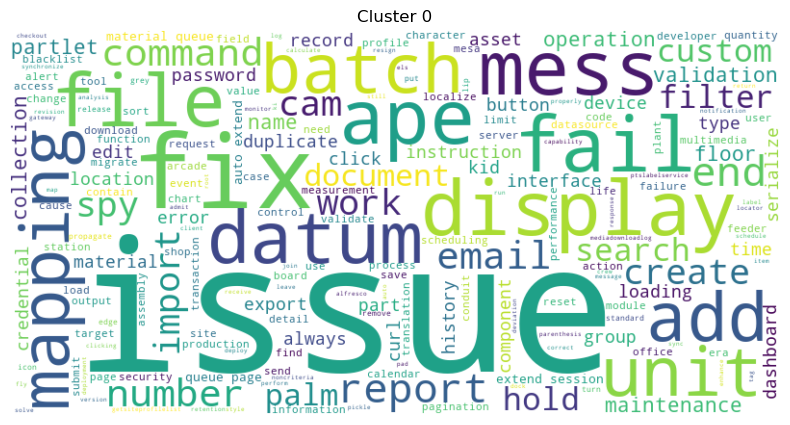

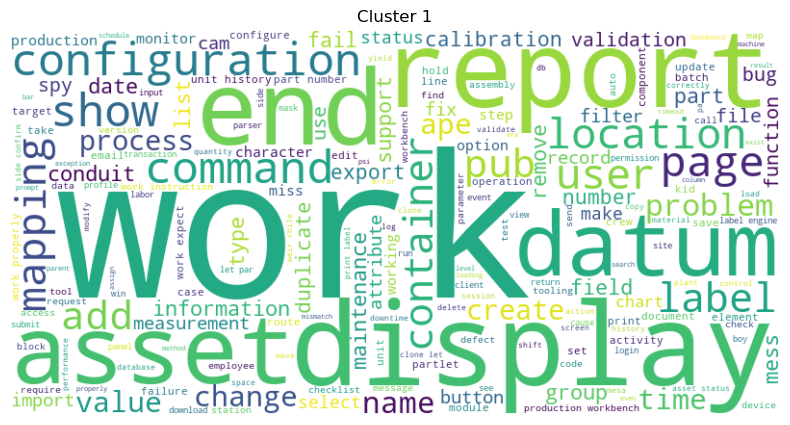

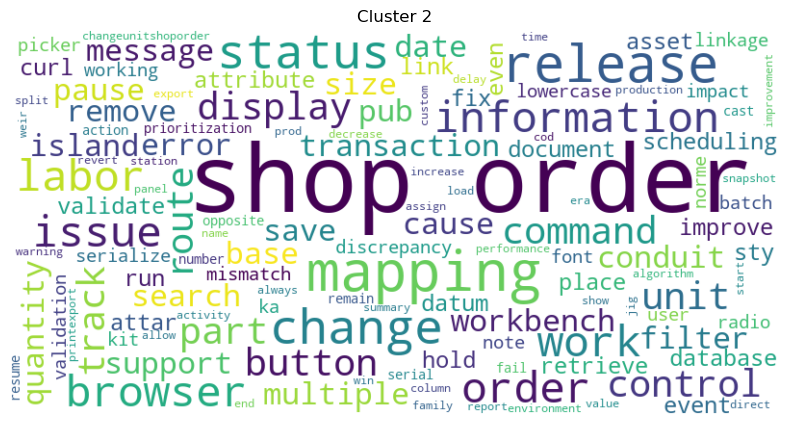

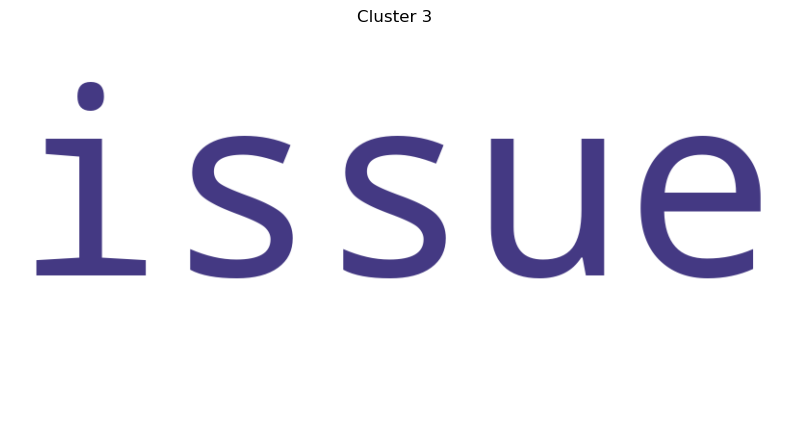

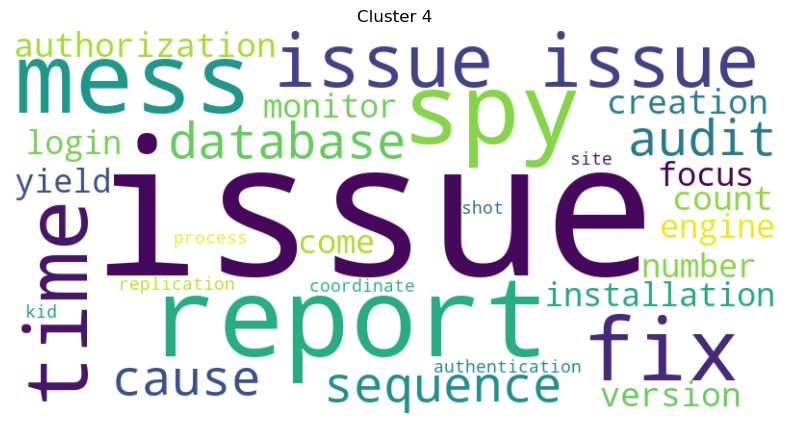

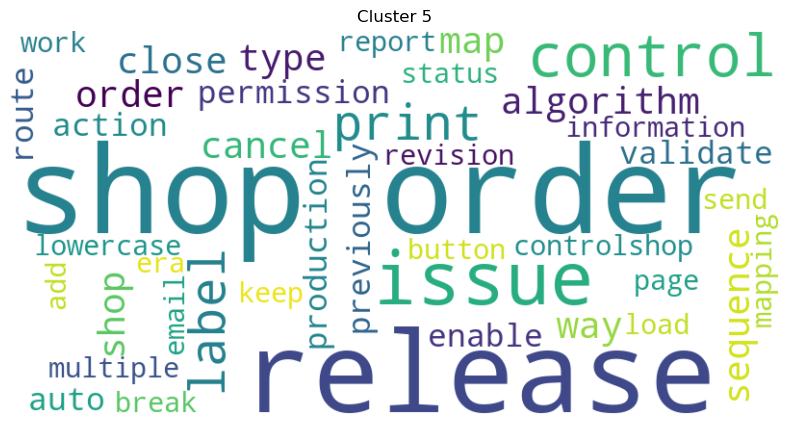

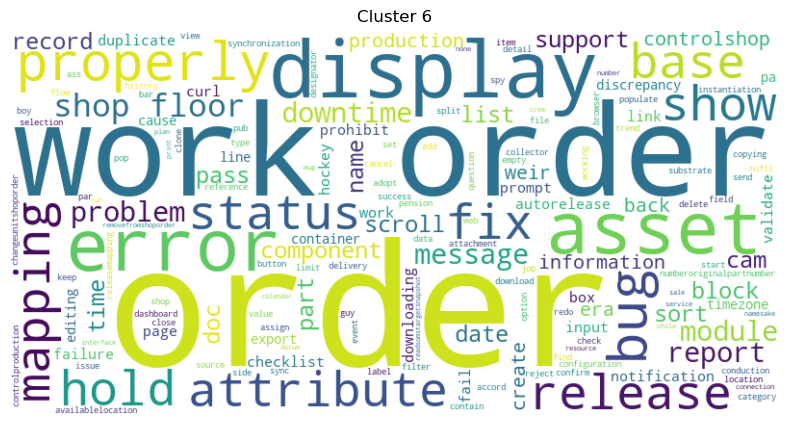

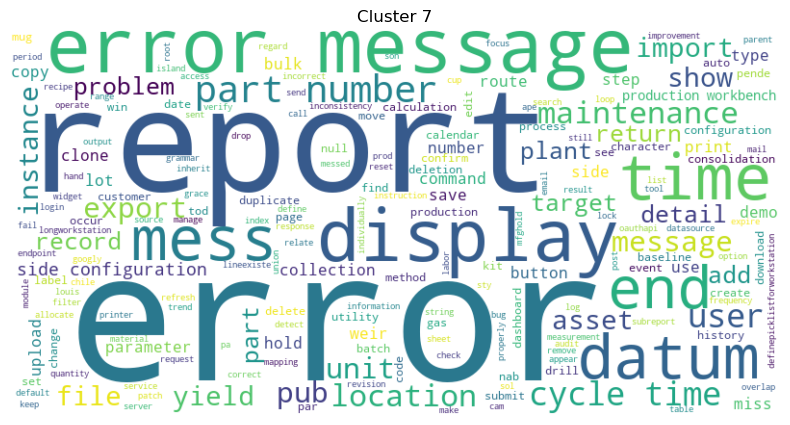

In [108]:
df['cluster'] = labels

for i in range(n_clusters):
    cluster_texts = ' '.join(df[df['cluster'] == i]['normalized_summary'])
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_texts)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Cluster {i}')
    plt.show()

In [109]:
df[df['cluster'] == 3]['Summary']

98                       SR#5527122 - MES2FUJI slow issue
917     SR#5278665 42Q Portal - general issue (Assembl...
971                       SR# 5112414 media issue for UAT
1114                                 Issues with CR#WT024
Name: Summary, dtype: object